In this notebook I am going to perform EDA and binary classification using catboost classifier.

**EDA:**

* Finding correlation between categorical features and target using swarmplots.
* Distribution plot for age.
* Plot of top countries participated in survey.

**Classification:**

Classification using catboost classifier.

Why catboost?
* Because we don't need to preprocess categorical features for using catboost.
* Handle class imbalance using class weights.

**Let's import all required packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn .metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

seed = 143
np.random.seed(seed)

%matplotlib inline

Load the data

In [2]:
df = pd.read_csv('../input/autism-screening-on-adults/autism_screening.csv')

In [3]:
len(df)

704

Glimpse the data

In [4]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2.0,18 and more,?,NO


In [5]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

## EDA

In [6]:
df.nunique()

A1_Score            2
A2_Score            2
A3_Score            2
A4_Score            2
A5_Score            2
A6_Score            2
A7_Score            2
A8_Score            2
A9_Score            2
A10_Score           2
age                46
gender              2
ethnicity          12
jundice             2
austim              2
contry_of_res      67
used_app_before     2
result             11
age_desc            1
relation            6
Class/ASD           2
dtype: int64

By looking at unique values for columns we can say that, all are categorical columns.

Since column 'age_desc' has just one value throughout the data, we can drop it.

In [7]:
df.drop(columns=['age_desc'], inplace=True)

Let's check for null values in data

In [8]:
df.isnull().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                2
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64

Age column has 2 nan values, let's replace them with 0.

In [9]:
df['age'].fillna(0, inplace=True)

Let's encode target class labels YES and NO with 0 and 1 respectively.

In [10]:
df['Class/ASD'] = df['Class/ASD'].apply(lambda x: int(x == 'YES'))

Let's plot individual categorical columns agaist target to see how they are related.

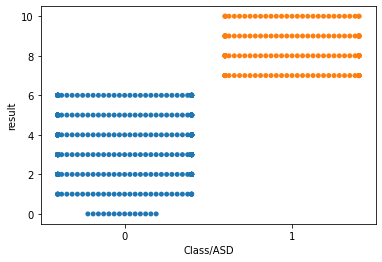

In [11]:
sns.swarmplot(x='Class/ASD', y='result', data=df)

We can clearly see from above plot that, result is highly correlated with Class/ASD. There is clear separation between class 0 and 1.

Observations:

if 
* result > 6 , Class/ASD = 1
* otherwise, Class/ASD = 0


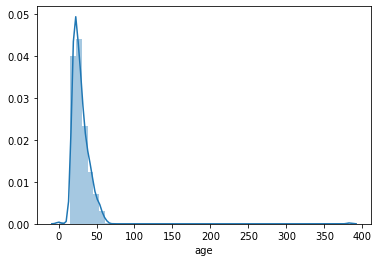

In [12]:
sns.distplot(df['age'])

From above plot we can say that, average age of candidates is somewhere around 25-30.

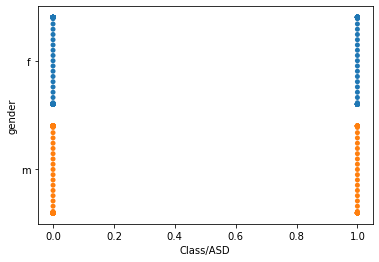

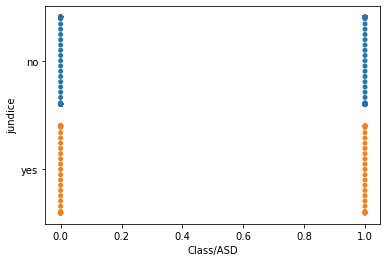

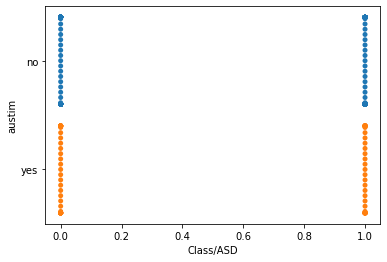

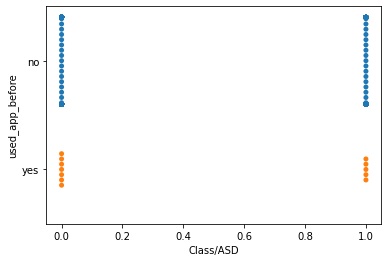

In [13]:
cols = ['gender','jundice','austim','used_app_before']
for i in cols:
    sns.swarmplot(x='Class/ASD', y=i, data=df)
    plt.show()

From above plots we can say that, no columns from above list shows correlation with target class. There is no clear separation of classes.

Let's plot top 15 countries participated in survey based on their count.

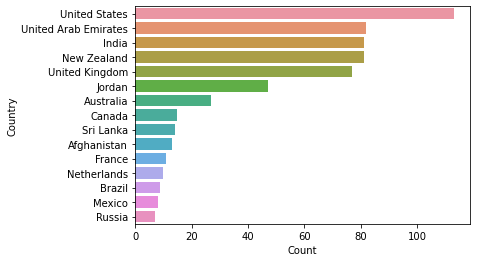

In [14]:
fig = sns.barplot(y=df['contry_of_res'].value_counts().index[:15], x=df['contry_of_res'].value_counts().values[:15], data=df)
fig.set(xlabel='Count', ylabel='Country')
plt.show()

## Prediction

In [15]:
df['Class/ASD'].value_counts()

0    515
1    189
Name: Class/ASD, dtype: int64

There is a class imbalance problem. We will handle this by specifying class_weights in classifier later.

Before jumping into building a classifier, let's shuffle the data and split it into train and test sets.

In [16]:
df = df.sample(frac=1, random_state=seed)
train_x,test_x,train_y,test_y = train_test_split(df.drop(columns=['Class/ASD']), df['Class/ASD'], test_size=0.2, random_state=seed)

Let's build the classifier.

In [17]:
cat_features = [i for i in df.columns if i not in ['Class/ASD', 'age', 'result']]

clf = CatBoostClassifier(
    iterations=10,
    verbose=5,
    class_weights = [1,2]
)

clf.fit(
    train_x, train_y ,
    cat_features=cat_features,
)

Learning rate set to 0.5
0:	learn: 0.3389700	total: 54.1ms	remaining: 487ms
5:	learn: 0.0399998	total: 59.1ms	remaining: 39.4ms
9:	learn: 0.0134532	total: 62.5ms	remaining: 0us


In [18]:
pred_y = clf.predict(test_x)

In [19]:
accuracy_score(pred_y, test_y)

1.0

In [20]:
f1_score(pred_y, test_y)

1.0

Perfect f1 score of 1!!

Let's find the feature importance.

In [21]:
clf.get_feature_importance()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.77220305e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.40209465e-01, 2.84794559e-02,
       1.20042722e+00, 0.00000000e+00, 3.36738108e-01, 0.00000000e+00,
       2.11070044e-01, 9.69314029e+01, 4.74452510e-01])